In [52]:
import torch
from torch.autograd import Variable
import numpy as np
import unittest
import torch.nn as nn

import matplotlib.pyplot as plt
from torchvision.datasets import MNIST
import torchvision.transforms as T
import torchvision

In [53]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [54]:
%run homework_modules.ipynb

## Оптимайзер под наши классы

In [55]:
class Adam:
    def __init__(self, model, lr=0.001, beta_1=0.9, beta_2=0.999, EPS=1e-8):
        self.lr = lr
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.EPS = EPS
        self.t = 0

        self.params = []
        self.grads = []

        for layer in model.models:
            layer_params = []
            layer_grads = []


            for attr_name in dir(layer):
                if attr_name.startswith('grad'):
                    param_name = attr_name[4:]
                    if hasattr(layer, param_name):
                        layer_params.append(getattr(layer, param_name))
                        layer_grads.append(getattr(layer, attr_name))

            if layer_params:
                self.params.append(layer_params)
                self.grads.append(layer_grads)

        self.m = [[np.zeros_like(p) for p in layer_params] for layer_params in self.params]
        self.v = [[np.zeros_like(p) for p in layer_params] for layer_params in self.params]

    def step(self):
        self.t += 1
        for i in range(len(self.params)):
            for j in range(len(self.params[i])):
                if self.grads[i][j] is None:
                    continue

                self.m[i][j] = self.beta_1 * self.m[i][j] + (1 - self.beta_1) * self.grads[i][j]
                self.v[i][j] = self.beta_2 * self.v[i][j] + (1 - self.beta_2) * (self.grads[i][j] ** 2)

                m_hat = self.m[i][j] / (1 - self.beta_1 ** self.t)
                v_hat = self.v[i][j] / (1 - self.beta_2 ** self.t)

                self.params[i][j] -= self.lr * m_hat / (np.sqrt(v_hat) + self.EPS)

    def zero_grad(self):
        for l in model.layers:
            l.zeroGradParameters()

## Мультирегрессия?

In [56]:
data = fetch_california_housing()
X = data.data
y = data.target.reshape(-1, 1)

y = np.hstack([y, X[:, 2].reshape(-1, 1)])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [58]:
def mse_loss(output, target):
    return np.mean((output - target) ** 2)

In [59]:
def train_model(model, optimizer, X_train, y_train, X_test, y_test, epochs=35):
    train_losses = []
    test_losses = []

    for epoch in range(epochs):
        model.zeroGradParameters()
        train_loss = 0

        for i in range(0, len(X_train), 32):
            X_batch = X_train[i:i+32]
            y_batch = y_train[i:i+32]

            output = model.updateOutput(X_batch)
            loss = mse_loss(output, y_batch)
            train_loss += loss

            grad_output = (output - y_batch) / len(X_batch)
            model.updateGradInput(X_batch, grad_output)
            model.accGradParameters(X_batch, grad_output)
            optimizer.step()

        train_losses.append(train_loss / (len(X_train) // 32))

        test_loss = 0
        for i in range(0, len(X_test), 32):
            X_batch = X_test[i:i+32]
            y_batch = y_test[i:i+32]

            output = model.forward(X_batch)
            test_loss += mse_loss(output, y_batch)

        test_losses.append(test_loss / (len(X_test) // 32))

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}")

    return train_losses, test_losses


In [60]:
class MyNN(Module):
    def __init__(self, in_features, num_classes, hide_neurons):
        super(MyNN, self).__init__()
        self.models = Sequential()
        self.models.modules.append(Linear(in_features, hide_neurons))
        self.models.modules.append(ReLU())
        self.models.modules.append(Linear(hide_neurons, num_classes))
        # self.models.modules.append(Linear(in_features, hide_neurons))
        # self.models.modules.append(BatchNormalization(hide_neurons))
        # self.models.modules.append(LeakyReLU())

        # self.models.modules.append(Linear(hide_neurons, hide_neurons // 2))
        # self.models.modules.append(BatchNormalization(hide_neurons // 2))
        # self.models.modules.append(LeakyReLU())

        # self.models.modules.append(Linear(hide_neurons // 2, num_classes))
    def updateOutput(self, x):
        for layer in self.models.modules:
            x = layer.updateOutput(x) if hasattr(layer, "updateOutput") else x
        return x
    # def updateGradInput(self, x, grad_output):
    #   for layer in reversed(self.models.modules):
    #       grad_output = layer.updateGradInput(x, grad_output) if hasattr(layer, "updateGradInput") else grad_output
    #   return grad_output
    # def updateGradInput(self, x, grad_output):
    #     for layer in reversed(self.models.modules):
    #         grad_output = layer.updateGradInput(grad_output) if hasattr(layer, "updateGradInput") else grad_output
    #     return grad_output
    def updateGradInput(self, x, grad_output):
        for i in range(len(self.models.modules) - 1, -1, -1):
            layer = self.models.modules[i]
            x = self.models.modules[i-1].output if i > 0 else x  # Берем правильный input
            grad_output = layer.updateGradInput(x, grad_output) if hasattr(layer, "updateGradInput") else grad_output
        return grad_output

    def accGradParameters(self, x, grad_output):
        for layer in self.models.modules:
            if hasattr(layer, "accGradParameters"):
                layer.accGradParameters(x, grad_output)

    def getParameters(self):
        params = []
        for layer in self.models.modules:
            if hasattr(layer, "getParameters"):
                params.extend(layer.getParameters())
        return params

    def getGradParameters(self):
        grads = []
        for layer in self.models.modules:
            if hasattr(layer, "getGradParameters"):
                grads.extend(layer.getGradParameters())
        return grads

    def zeroGradParameters(self):
        for layer in self.models.modules:
            if hasattr(layer, "zeroGradParameters"):
                layer.zeroGradParameters()

    def train(self):
        """Метод для включения режима обучения."""
        pass

    def eval(self):
        """Метод для включения режима оценки."""
        pass

In [61]:
def r2_score(y_true, y_pred):
    ss_total = np.sum((y_true - np.mean(y_true)) ** 2)
    ss_residual = np.sum((y_true - y_pred) ** 2)
    return 1 - (ss_residual / ss_total)

In [62]:
def train_model(model, optimizer, X_train, y_train, X_test, y_test, epochs=99):
    train_losses = []
    test_losses = []
    train_r2_scores = []
    test_r2_scores = []

    for epoch in range(epochs):
        model.zeroGradParameters()
        train_loss = 0
        train_r2 = 0

        for i in range(0, len(X_train), 32):
            X_batch = X_train[i:i+32]
            y_batch = y_train[i:i+32]

            output = model.updateOutput(X_batch)
            loss = mse_loss(output, y_batch)
            train_loss += loss


            train_r2 += r2_score(y_batch, output)

            grad_output = (output - y_batch) / len(X_batch)
            model.updateGradInput(X_batch, grad_output)
            model.accGradParameters(X_batch, grad_output)
            optimizer.step()

        train_losses.append(train_loss / (len(X_train) // 32))
        train_r2_scores.append(train_r2 / (len(X_train) // 32))


        test_loss = 0
        test_r2 = 0
        for i in range(0, len(X_test), 32):
            X_batch = X_test[i:i+32]
            y_batch = y_test[i:i+32]

            output = model.updateOutput(X_batch)
            test_loss += mse_loss(output, y_batch)


            test_r2 += r2_score(y_batch, output)

        test_losses.append(test_loss / (len(X_test) // 32))
        test_r2_scores.append(test_r2 / (len(X_test) // 32))


        # print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}, Train R²: {train_r2_scores[-1]:.4f}, Test R²: {test_r2_scores[-1]:.4f}")

    return train_losses, test_losses, train_r2_scores, test_r2_scores

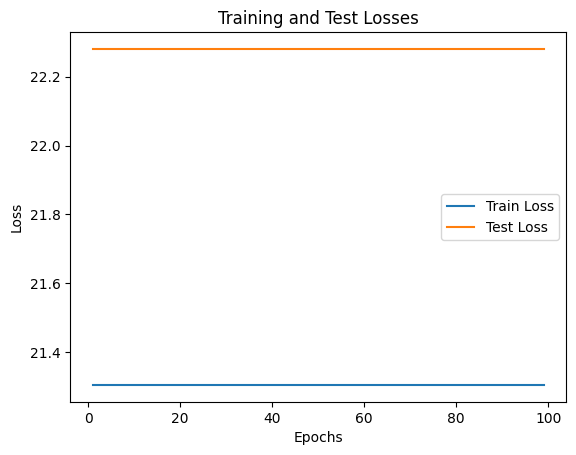

In [63]:
model = MyNN(in_features=X_train.shape[1], num_classes=y_train.shape[1], hide_neurons=16)
optimizer = Adam(model, lr=0.9)


train_losses, test_losses, train_r2_scores, test_r2_scores = train_model(model, optimizer, X_train, y_train, X_test, y_test)


plt.plot(range(1, 100), train_losses, label='Train Loss')
plt.plot(range(1, 100), test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Test Losses')
plt.legend()
plt.show()

## Попытка 2....

In [64]:
class MyNN(Module):
    def __init__(self, in_features, num_classes, hide_neurons):
        super(MyNN, self).__init__()
        self.models = Sequential()
        self.models.modules.append(Linear(in_features, hide_neurons))
        self.models.modules.append(BatchNormalization(hide_neurons))
        self.models.modules.append(LeakyReLU())

        self.models.modules.append(Linear(hide_neurons, hide_neurons // 2))
        self.models.modules.append(BatchNormalization(hide_neurons // 2))
        self.models.modules.append(LeakyReLU())

        self.models.modules.append(Linear(hide_neurons // 2, num_classes))

    def updateOutput(self, x):
        for layer in self.models.modules:
            if hasattr(layer, "updateOutput"):
                x = layer.updateOutput(x)
        self.output = x
        return x

    # def updateOutput(self, x):
    #     for layer in self.models.modules:
    #         x = layer.updateOutput(x) if hasattr(layer, "updateOutput") else x
    #     return x
    # def updateGradInput(self, x, grad_output):
    #   for layer in reversed(self.models.modules):
    #       grad_output = layer.updateGradInput(x, grad_output) if hasattr(layer, "updateGradInput") else grad_output
    #   return grad_output
    # def updateGradInput(self, x, grad_output):
    #     for layer in reversed(self.models.modules):
    #         grad_output = layer.updateGradInput(grad_output) if hasattr(layer, "updateGradInput") else grad_output
    #     return grad_output
    def updateGradInput(self, x, grad_output):
        for i in range(len(self.models.modules) - 1, -1, -1):
            layer = self.models.modules[i]
            x = self.models.modules[i-1].output if i > 0 else x
            grad_output = layer.updateGradInput(x, grad_output) if hasattr(layer, "updateGradInput") else grad_output
        return grad_output

    def accGradParameters(self, x, grad_output):
        for layer in self.models.modules:
            if hasattr(layer, "accGradParameters"):
                layer.accGradParameters(x, grad_output)

    def getParameters(self):
        params = []
        for layer in self.models.modules:
            if hasattr(layer, "getParameters"):
                params.extend(layer.getParameters())
        return params

    def getGradParameters(self):
        grads = []
        for layer in self.models.modules:
            if hasattr(layer, "getGradParameters"):
                grads.extend(layer.getGradParameters())
        return grads

    def zeroGradParameters(self):
        for layer in self.models.modules:
            if hasattr(layer, "zeroGradParameters"):
                layer.zeroGradParameters()

    def train(self):
        """Метод для включения режима обучения."""
        pass

    def eval(self):
        """Метод для включения режима оценки."""
        pass

<ipython-input-54-3da6f7731f21>:19: RuntimeWarning: overflow encountered in multiply
  self.moving_mean = self.moving_mean * self.alpha + batch_mean * (1 - self.alpha)
<ipython-input-54-3da6f7731f21>:20: RuntimeWarning: overflow encountered in multiply
  self.moving_variance = self.moving_variance * self.alpha + batch_variance * (1 - self.alpha)


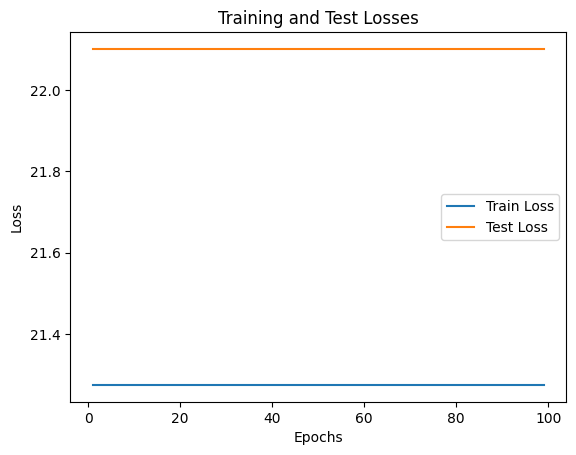

In [65]:
model = MyNN(in_features=X_train.shape[1], num_classes=y_train.shape[1], hide_neurons=16)
optimizer = Adam(model, lr=0.9)

train_losses, test_losses, train_r2_scores, test_r2_scores = train_model(model, optimizer, X_train, y_train, X_test, y_test)

plt.plot(range(1, 100), train_losses, label='Train Loss')
plt.plot(range(1, 100), test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Test Losses')
plt.legend()
plt.show()